In [1]:
import pickle
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_pickle(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)
        return data

In [3]:
def flatten_data(data):
    flat_list_of_arrays = [item for sublist in data for item in sublist]
    data = np.vstack(flat_list_of_arrays)
    return data

In [4]:
pca = PCA(n_components=2, random_state=42)

In [5]:
yake_data = load_pickle('yake_embeddings.pkl')
textrank_data = load_pickle('textrank_embeddings.pkl')
bert_data = load_pickle('bert_embeddings.pkl')
all_data = np.concatenate([yake_data, textrank_data, bert_data], axis=0)
flattened_data = flatten_data(all_data)
embedded_data = pca.fit_transform(flattened_data)

yake_data = embedded_data[:int(len(embedded_data)/3)]
textrank_data = embedded_data[int(len(embedded_data)/3):int(2 * len(embedded_data)/3)]
bert_data = embedded_data[int(2 * len(embedded_data)/3):int(len(embedded_data))]

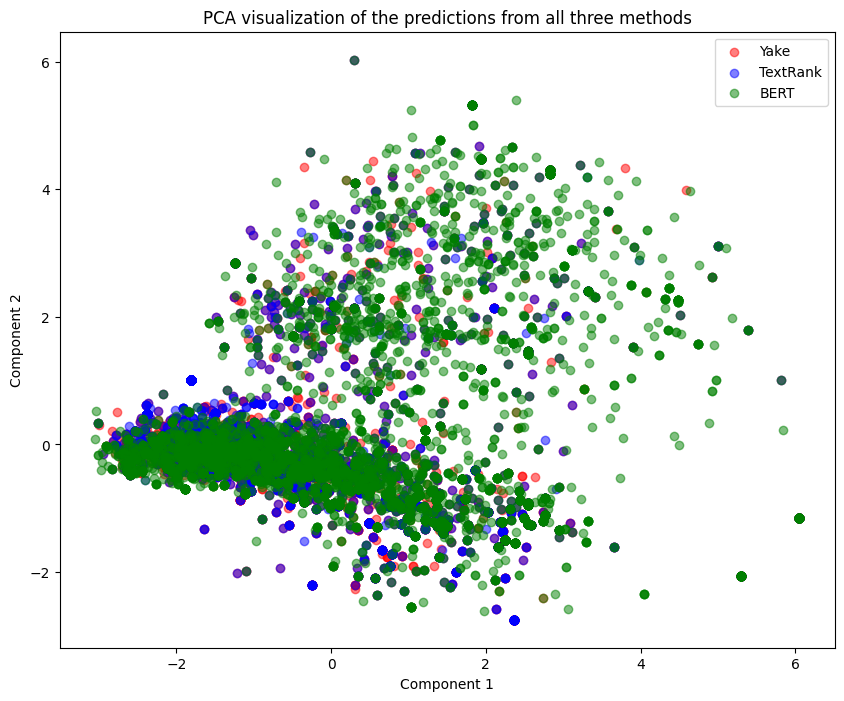

In [6]:
plt.figure(figsize=(10, 8))

plt.scatter(yake_data[:, 0], yake_data[:, 1], c='red', label='Yake', alpha=0.5)
plt.scatter(textrank_data[:, 0], textrank_data[:, 1], c='blue', label='TextRank', alpha=0.5)
plt.scatter(bert_data[:, 0], bert_data[:, 1], c='green', label='BERT', alpha=0.5)

plt.title('PCA visualization of the predictions from all three methods')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [7]:
import pandas as pd
import json

In [8]:
keywords = pd.read_csv('keywords_merged.csv')
keywords['BertKeyWords'] = keywords['BertKeyWords'].apply(json.loads)
keywords['YakeKeyWords'] = keywords['YakeKeyWords'].apply(json.loads)
keywords['TextRankKeywords'] = keywords['TextRankKeywords'].apply(json.loads)

In [9]:
from adjustText import adjust_text

In [10]:
def generate_plots(text_num, embeddings1, embeddings2, col_name1, col_name2, algo_name1, algo_name2):
    upper_limit = text_num * 10
    lower_limit = upper_limit - 10
    plt.figure(figsize=(10, 8))

    x_yake, y_yake = embeddings1[lower_limit:upper_limit, 0], embeddings1[lower_limit:upper_limit, 1]
    plt.scatter(x_yake, y_yake, c='red', label=algo_name1, alpha=0.5)

    texts = []
    for i, (x, y) in enumerate(zip(x_yake, y_yake)):
        texts.append(plt.text(x, y, keywords[col_name1][text_num - 1][i], ha='center', va='center'))

    x_bert, y_bert = embeddings2[lower_limit:upper_limit, 0], embeddings2[lower_limit:upper_limit, 1]
    plt.scatter(x_bert, y_bert, c='green', label=algo_name2, alpha=0.5)
    for i, (x, y) in enumerate(zip(x_bert, y_bert)):
        texts.append(plt.text(x, y, keywords[col_name2][text_num - 1][i], ha='center', va='center'))

    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

    plt.title(f'PCA visualization of {algo_name1} and {algo_name2} Keyword Embeddings for a sample article')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

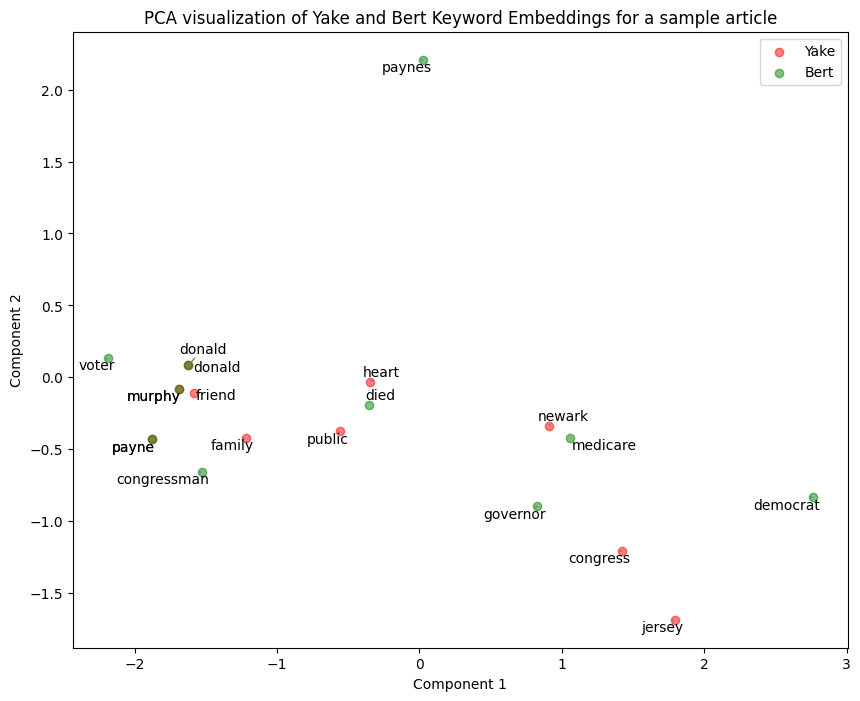

In [11]:
generate_plots(2, yake_data, bert_data,'YakeKeyWords', 'BertKeyWords', 'Yake', 'Bert')

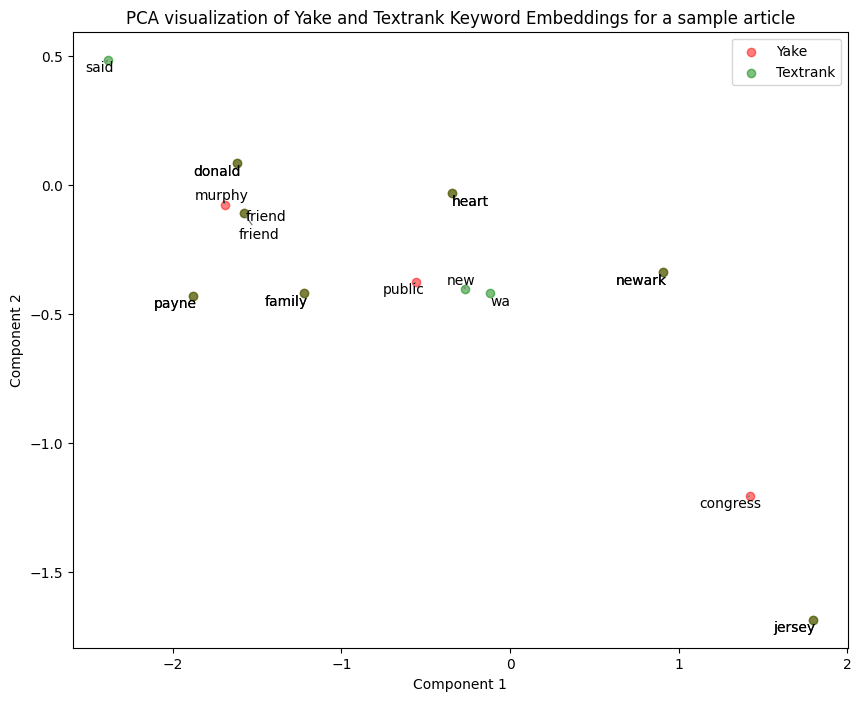

In [12]:
generate_plots(2, yake_data, textrank_data, 'YakeKeyWords', 'TextRankKeywords', 'Yake', 'Textrank')

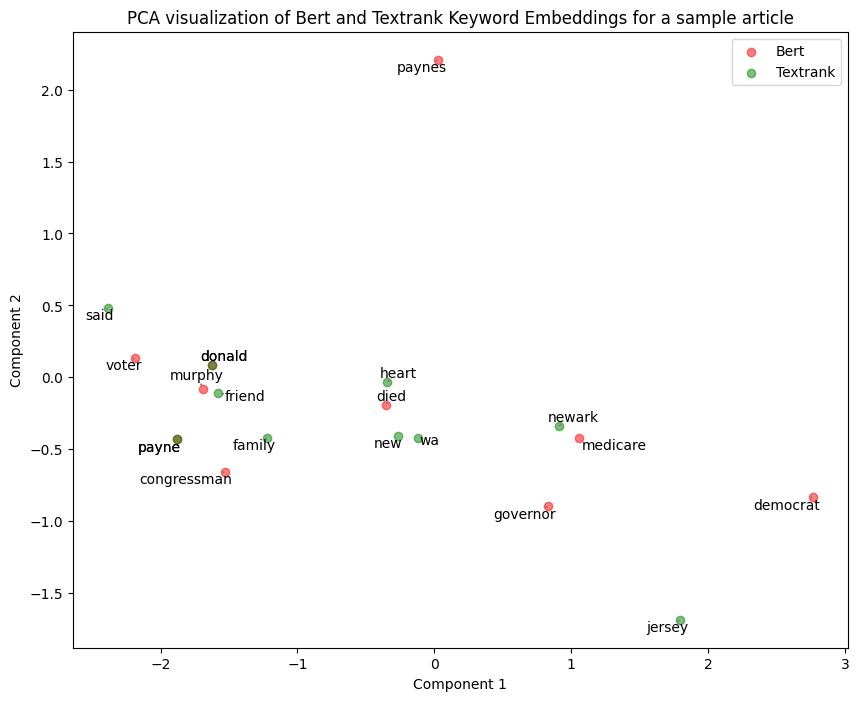

In [13]:
generate_plots(2, bert_data, textrank_data, 'BertKeyWords', 'TextRankKeywords', 'Bert', 'Textrank')

In [14]:
bert_keywords = keywords['BertKeyWords']
yake_keywords = keywords['YakeKeyWords']
textrank_keywords = keywords['TextRankKeywords']

In [15]:
import jaro
from Levenshtein import distance as levenshtein_distance

In [16]:
# calculates average metrics for all keywords from set 1 in relation to keywords from set 2
# we take each keyword from set 1 and check the metrics by taking most similar word from set 2
def calculate_metrics(keywords1, keywords2, num_keywords):
    levenshtein_results = []
    jaro_winkler_results = []
    for keyword_list1, keyword_list2 in zip(keywords1, keywords2):
        jaro_partial = 0
        levenshtein_partial = 0
        for keyword1 in keyword_list1:
            max_jaro = 0
            min_levenshtein = float('inf')
            for keyword2 in keyword_list2:
                jaro_k1_k2 = jaro.jaro_winkler_metric(keyword1, keyword2)
                levenshtein_k1_k2 = levenshtein_distance(keyword1, keyword2)
                if jaro_k1_k2 > max_jaro:
                    max_jaro = jaro_k1_k2
                if levenshtein_k1_k2 < min_levenshtein:
                    min_levenshtein = levenshtein_k1_k2
                    
            jaro_partial += max_jaro
            levenshtein_partial += min_levenshtein
        jaro_winkler_results.append(jaro_partial/num_keywords)
        levenshtein_results.append(levenshtein_partial/num_keywords)
    
    return jaro_winkler_results, levenshtein_results

In [17]:
def calculate_average_metrics(keywords1, keywords2):
    levenshtein_results = []
    jaro_winkler_results = []
    for keyword_list1, keyword_list2 in zip(keywords1, keywords2):
        all_jaro = []
        all_levenshtein = []
        for keyword1 in keyword_list1:
            for keyword2 in keyword_list2:
                jaro_score = jaro.jaro_winkler_metric(keyword1, keyword2)
                levenshtein_score = levenshtein_distance(keyword1, keyword2)
                all_jaro.append(jaro_score)
                all_levenshtein.append(levenshtein_score)
        
        average_jaro = sum(all_jaro) / len(all_jaro)
        average_levenshtein = sum(all_levenshtein) / len(all_levenshtein)
        jaro_winkler_results.append(average_jaro)
        levenshtein_results.append(average_levenshtein)
    
    return jaro_winkler_results, levenshtein_results


In [18]:
from statistics import mean

In [19]:
results_jaro_bert_yake, results_levenshtein_bert_yake = calculate_metrics(bert_keywords, yake_keywords, 10)
results_jaro_bert_textrank, results_levenshtein_bert_textrank = calculate_metrics(bert_keywords, textrank_keywords, 10)
results_jaro_yake_textrank, results_levenshtein_yake_textrank = calculate_metrics(yake_keywords, textrank_keywords, 10)

In [20]:
mean(results_jaro_bert_yake)

0.7532180358833511

In [21]:
mean(results_levenshtein_bert_yake)

3.743151969981238

In [22]:
average_jaro_bert_yake, average_levenshtein_bert_yake = calculate_average_metrics(bert_keywords, yake_keywords)

In [23]:
mean(average_levenshtein_bert_yake)

6.97671669793621

In [24]:
yake_data = load_pickle('yake_embeddings.pkl')
textrank_data = load_pickle('textrank_embeddings.pkl')
bert_data = load_pickle('bert_embeddings.pkl')

In [25]:
from scipy.spatial.distance import cosine

In [26]:
def cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

In [27]:
def calculate_cosine_similarity(keywords1, keywords2, num_keywords):
    cosine_similarity_results = []
    for embeddings_list1, embeddings_list2 in zip(keywords1, keywords2):
        cosine_partial = 0
        for keyword1 in embeddings_list1:
            max_cosine_similarity = -1
            for keyword2 in embeddings_list2:
                cosine_similarity_k1_k2 = cosine_similarity(np.squeeze(keyword1), np.squeeze(keyword2))
                if cosine_similarity_k1_k2 > max_cosine_similarity:
                    max_cosine_similarity = cosine_similarity_k1_k2
            cosine_partial += max_cosine_similarity
        cosine_similarity_results.append(cosine_partial/num_keywords)
    return cosine_similarity_results

In [28]:
cossim_bert_yake = calculate_cosine_similarity(bert_data, yake_data, 10)
cossim_bert_textrank = calculate_cosine_similarity(bert_data, textrank_data, 10)
cossim_yake_textrank = calculate_cosine_similarity(yake_data, textrank_data, 10)

In [29]:
def generate_metric_plot(metric_results, metric_name, algo_name1, algo_name2):
    indexes = list(range(len(metric_results)))

    plt.figure(figsize=(15, 10))  
    plt.plot(indexes, metric_results, marker='o', linestyle='-', color='b')
    plt.title(f'Values of {metric_name} for {algo_name1} and {algo_name2}')
    plt.xlabel('Element index') 
    plt.ylabel(f'{metric_name} value')  
    plt.grid(True)
    
    plt.gca().set_facecolor('white')
    plt.gcf().set_facecolor('white')

    plt.xticks(ticks=[i for i in indexes if i % 100 == 0])
    
    plt.show() 
    

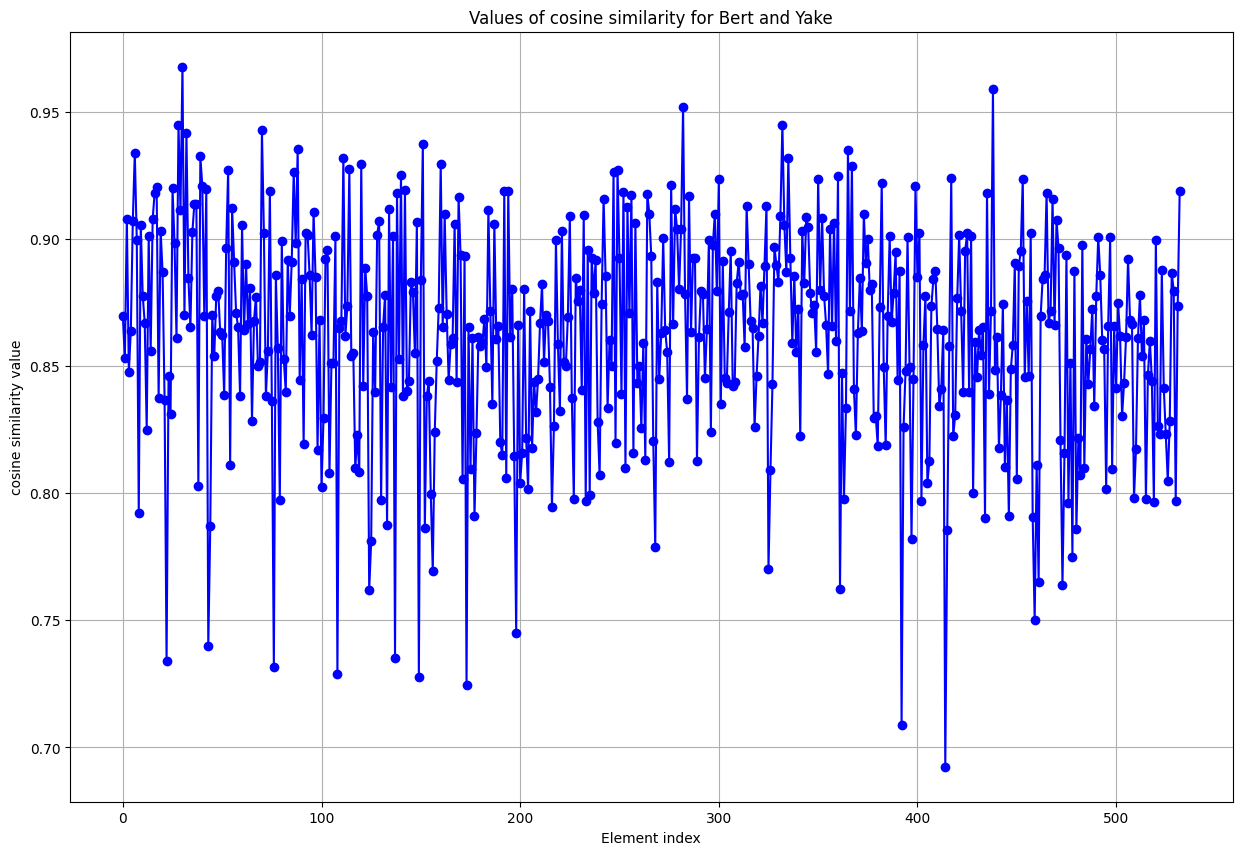

In [30]:
generate_metric_plot(cossim_bert_yake, 'cosine similarity', 'Bert', 'Yake')

In [31]:
print(f"Mean: {mean(cossim_bert_yake)}")
print(f"Max: {max(cossim_bert_yake)}")
print(f"Min: {min(cossim_bert_yake)}")

Mean: 0.8620400686964342
Max: 0.9676150607081965
Min: 0.692409477144259


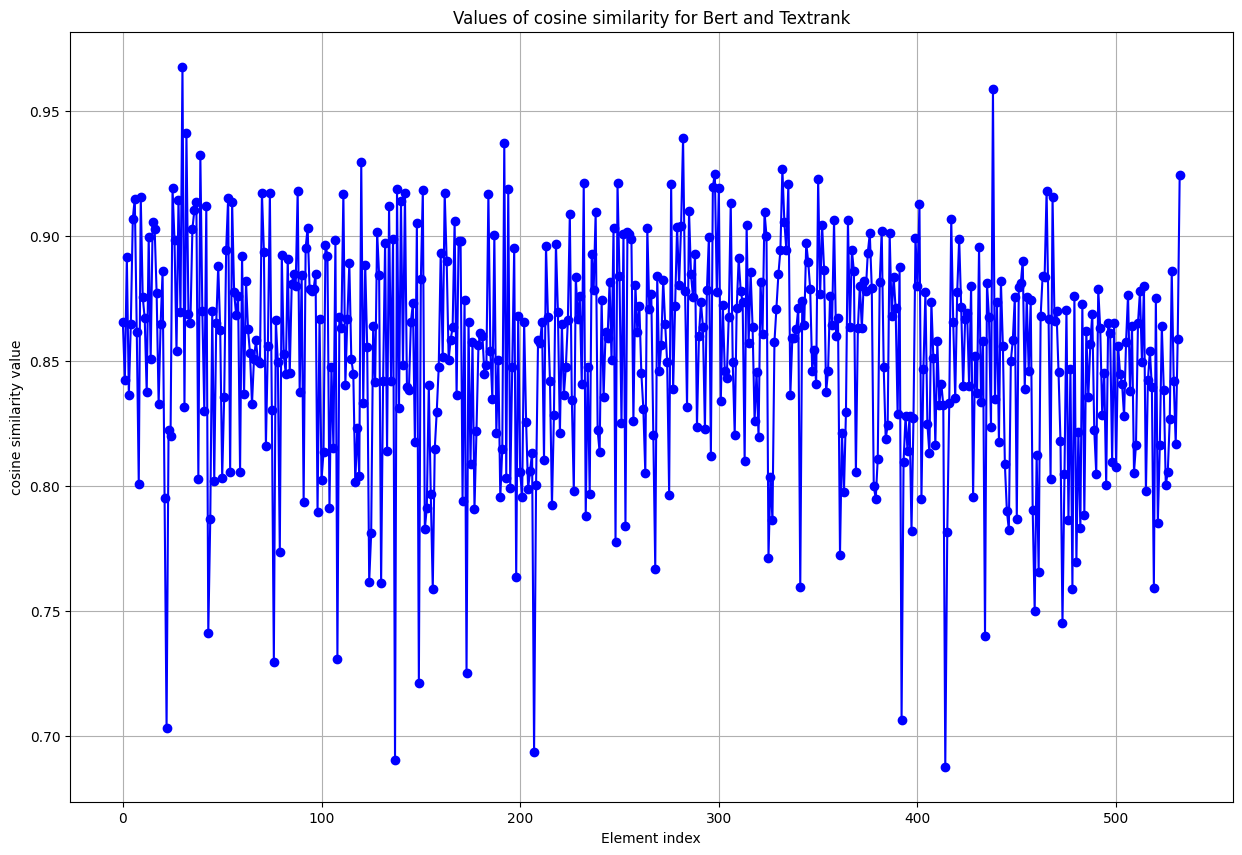

In [32]:
generate_metric_plot(cossim_bert_textrank, 'cosine similarity', 'Bert', 'Textrank')

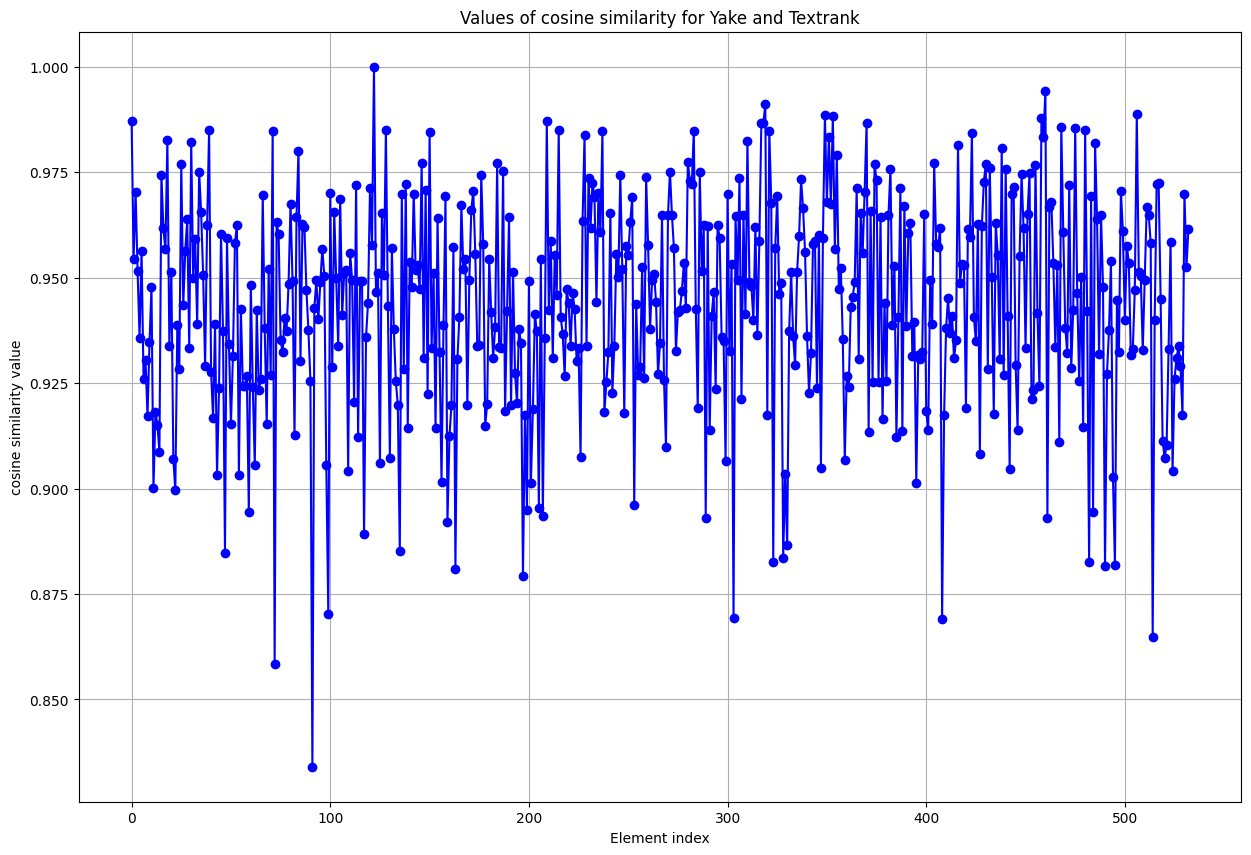

In [33]:
generate_metric_plot(cossim_yake_textrank, 'cosine similarity', 'Yake', 'Textrank')

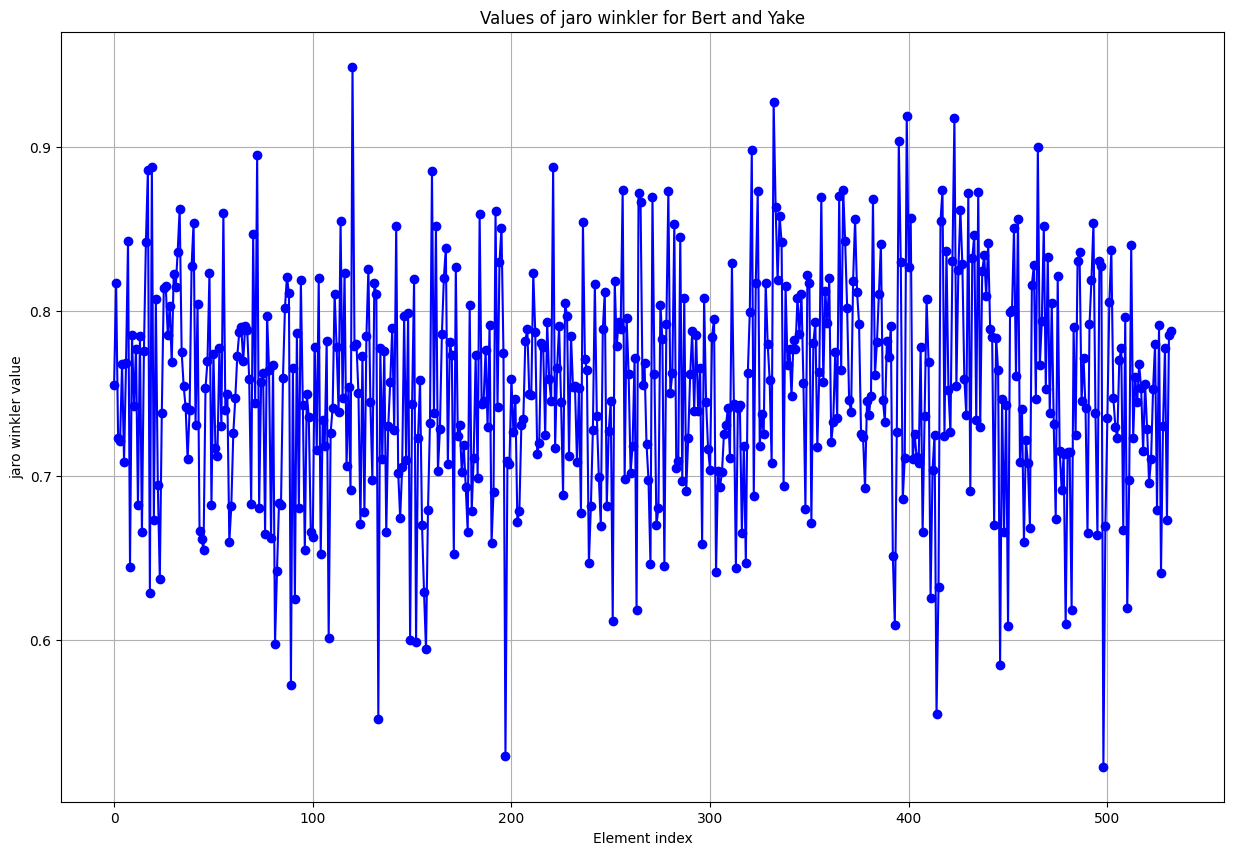

In [34]:
generate_metric_plot(results_jaro_bert_yake, 'jaro winkler', 'Bert', 'Yake')

In [35]:
print(f"Mean: {mean(results_jaro)}")
print(f"Max: {max(results_jaro)}")
print(f"Min: {min(results_jaro)}")

NameError: name 'results_jaro' is not defined

In [ ]:
generate_metric_plot(results_levenshtein, 'levenshtein')

In [ ]:
print(f"Mean: {mean(results_levenshtein)}")
print(f"Max: {max(results_levenshtein)}")
print(f"Min: {min(results_levenshtein)}")